In [1]:
import numpy as np
import pandas as pd
from scipy import optimize
from scipy.constants import mu_0, epsilon_0
from scipy import fftpack
from scipy import sparse
from scipy.special import factorial
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d, CubicSpline, BSpline
from scipy.sparse import csr_matrix, csc_matrix
import csv
from scipy.special import roots_legendre, eval_legendre
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.linalg import lu_factor, lu_solve
from scipy import signal
import ipywidgets
import discretize
import  os
import json
from PIL import Image
import seaborn as sns
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
import ipywidgets as widgets
eps = np.finfo(float).eps

In [2]:
import empymod
from masa_utils import PsuedoLog
from masa_utils import Pelton_res_f, DDR_f
from masa_utils import InducedPolarizationSimulation 
from masa_utils import Optimization 
from masa_utils import empymod_IP_simulation
from masa_utils import TEM_Signal_Process


Simulatin and synthetic study on deep sea hydrothermal deposits explortaion using WISTEM (K. Nakayama and A. Saito, 2016) (K.Nakayama M. Motoori and A. Saito,2019). On-Time: 200msec ramp time: 200usec Transmitter Loop: 3.5m Square Loop Receiver Loop: Coincident-type Number of Turn: 5 3.5m rectangular loop has equivalent area for 2.0m circular loop.

In [3]:
base_freq=1.25
on_time=0.2
rmp_time=200e-6
rec_time=3e-2
smp_freq=50e3 #200e3  

In [4]:
tx_side = 3.5
tx_radius = (tx_side)/(np.sqrt(np.pi))
tx_circumeference = 2*np.pi*tx_radius
tx_surface = np.pi*tx_radius**2
n_turns = 5
tx_depth = 0
print(f"Transmitter radius: {tx_radius}")

Transmitter radius: 1.9746635424171473


In [5]:
tstrt, tend = 1e-4, 3e-2
logstep = 1/15
WISTEM_SP_sim = TEM_Signal_Process(
    # base_freq=base_freq,
    # on_time=on_time, 
    rmp_time=rmp_time, 
    rec_time=tend, 
    smp_freq=smp_freq
)


In [6]:
times_sim = WISTEM_SP_sim.times_rec
times_clc = WISTEM_SP_sim.times_rec
ntimes = len(times_clc)
print(ntimes)
print(times_clc[:3], times_clc[-3:])
WISTEM_SP_sim.get_window_log(tstart=tstrt,logstep=logstep)
windows_strt = WISTEM_SP_sim.windows_strt
windows_cen = WISTEM_SP_sim.windows_cen
windows_end = WISTEM_SP_sim.windows_end
print(windows_cen-rmp_time)

1500
[2.e-05 4.e-05 6.e-05] [0.02996 0.02998 0.03   ]
[0.0001     0.00011659 0.00013594 0.00015849 0.00018478 0.00021544
 0.00025119 0.00029286 0.00034145 0.00039811 0.00046416 0.00054117
 0.00063096 0.00073564 0.0008577  0.001      0.00116591 0.00135936
 0.00158489 0.00184785 0.00215443 0.00251189 0.00292864 0.00341455
 0.00398107 0.00464159 0.0054117  0.00630957 0.00735642 0.00857696
 0.01       0.01165914 0.01359356 0.01584893 0.0184785  0.02154435
 0.02511886 0.02928645]


In [7]:
nlayer =1

rho0_target = 0.3
eta_target = 0.4
eta_sea , eta_base = 0.,0.
c_target = 0.4 
thick_target = 10.
tau_target = 3e-2

res_sea = 0.3
res_base = 1.0
tau_sea, tau_base, tau_ref = 3.0e-2, 1.0e-3, 1.0e-3
c_sea, c_base, c_ref = 0.4,0.4,0.4
depth = np.r_[0, thick_target]
print(f"depth {depth}")
tx_height = 0.3 #csx
print(tx_height)

depth [ 0. 10.]
0.3


In [8]:
nmodel=3
# m_true  = np.r_[np.log(0.3), 0.4, np.log(3e-2), 0.4]
m_true =  np.r_[np.log(rho0_target), eta_target, np.log(tau_target), c_target]
m_trues = [m_true, m_true, m_true]

In [9]:
WISTEM_SP_sim.get_window_log(tstart=tstrt,logstep=logstep)
filt_linrmp = WISTEM_SP_sim.filter_linear_rmp()

Window_mat = WISTEM_SP_sim.get_window_matrix(times_sim)
print(Window_mat.shape)

(38, 1500)


In [10]:
recx, recy = 0 , 0
recBdple = [recx, recy, tx_depth ,0,90]
# recx, recy, recw = rec_area(3, tx_side)
# recBdple = [recx, recy, tx_depth ,0,90]

In [11]:
# emoymod model to simulate WISTEM setting
# Note that it simulate only dBdt field at center of the transmitter loop
# User should multiply by area of the loop to get EMF(V/A)
empymod_model_sim = {
    # simulate each bipole of four side of the transmitter loop
    'src': [ tx_side/2, tx_side/2,  # x1,x2
                     0, tx_side/2,  # y1,y2
             tx_depth, tx_depth], # z1,z2
    # receiver at the center of the transmitter loop
    'rec': recBdple, # [recx, recy, tx_depth ,0,90], # dBzdt at x,y,z,azimuth,dip
    'depth': depth,
#    'res' : res,
    'freqtime': times_sim,
    'signal': None, #0, # 0: impulse or dBdt, 1: Stepoff or B field
    'msrc' : False, # Electric source
    'mrec' : True, # Magnetic receiver
    'strength': 8.*n_turns* tx_surface * mu_0,  
    'srcpts' : 3,  # Three works for the momtent, maybe worth seeking other number
    'verb': 0, # put 4 for more information
     # Setting xdirect=True can help, as direct field is then computed analytically in f-domain
    'xdirect': True,
}

In [12]:
sim_obs=empymod_IP_simulation(ip_model='pelton',
    model_base=empymod_model_sim, nlayer=nlayer,tx_height=tx_height,
    times=times_sim, smp_freq=smp_freq
    )
sim_obs.deepsea_signle_layer(
        res_sea=res_sea, res_base=res_base, eta_sea=eta_sea, eta_base=eta_base  
        )


In [13]:
print(sim_obs.m_fix)
print(sim_obs.model_base)

[-1.2039728   0.          0.          0.          0.          0.
 -6.90775528  0.         -6.90775528  0.4         0.          0.4       ]
{'src': [1.75, 1.75, 0, 1.75, 0, 0], 'rec': [0, 0, 0, 0, 90], 'depth': array([ 0., 10.]), 'freqtime': array([2.000e-05, 4.000e-05, 6.000e-05, ..., 2.996e-02, 2.998e-02,
       3.000e-02], shape=(1500,)), 'signal': None, 'msrc': False, 'mrec': True, 'strength': np.float64(0.0006157521600223001), 'srcpts': 3, 'verb': 0, 'xdirect': True}


In [14]:
sim_obs.cut_off = None
sim_obs.filt_curr = None
sim_obs.window_mat= None
mvec_obs = m_trues[0]
dpred_step= sim_obs.dpred(mvec_obs)
sim_obs.cut_off = smp_freq/2.0
print(f"cutoff frequency: {sim_obs.cut_off}")
dpred_LPF = sim_obs.dpred(mvec_obs)
sim_obs.filt_curr = filt_linrmp
dpred_rmp = sim_obs.dpred(mvec_obs)
sim_obs.window_mat=Window_mat
dpred_window = sim_obs.dpred(mvec_obs)

cutoff frequency: 25000.0


In [15]:
PL_decay = PsuedoLog(
    logmin=1e-8,
    linScale=1.0,
    logminx=1e-4,
    linScalex=0.5
    )
PL_filt = PsuedoLog(
    logmin=1e-7,
    linScale=0.2,
    logminx=1e-4,
    linScalex=0.2
    )
PL_jac = PsuedoLog(
    logmin=1e-1,
    linScale=0.5,
    logminx=1e-4,
    linScalex=0.2
    )


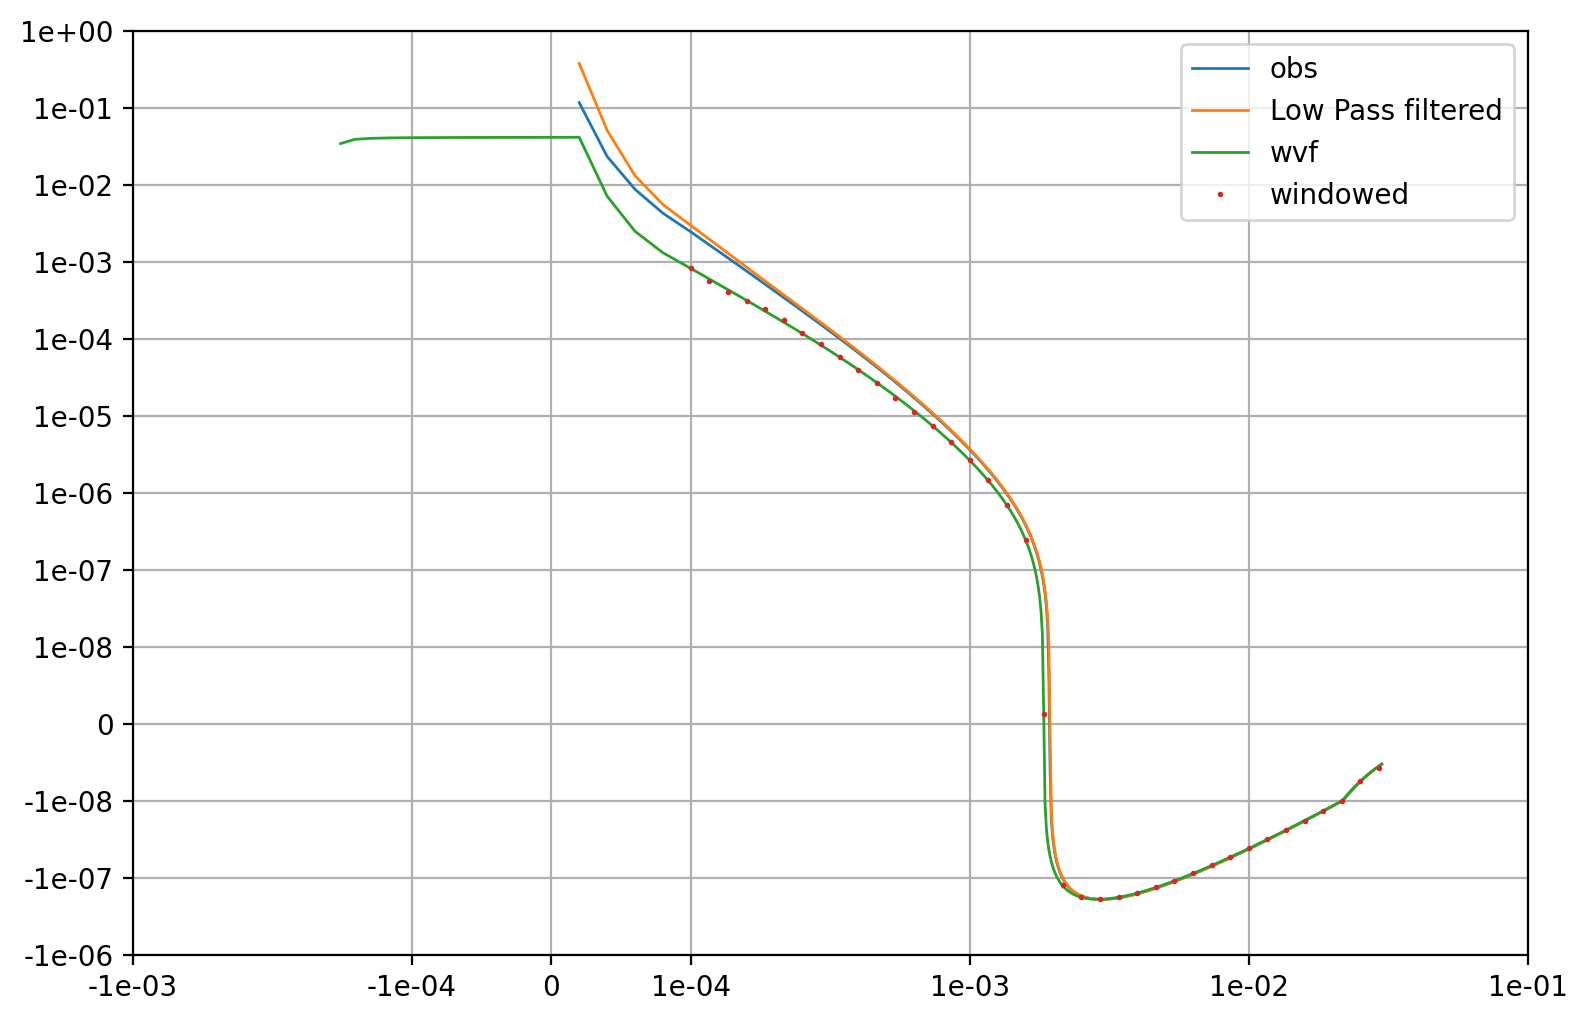

In [16]:
fig, ax= plt.subplots(1,1, figsize=(9,6), dpi=200)

ax=PL_decay.plpl_plot(
     x=times_clc,y=dpred_step , linestyle="-",label="obs", color="C0",ax=ax)
ax=PL_decay.plpl_plot(
     x=times_clc,y=dpred_LPF , linestyle="-",label="Low Pass filtered", color="C1",ax=ax)
ax=PL_decay.plpl_plot(
     x=times_clc-rmp_time,y=dpred_rmp , linestyle="-",label="wvf", color="C2",ax=ax)
ax=PL_decay.plpl_plot(
     x= windows_cen-rmp_time,y=dpred_window , marker="o",linestyle="",label="windowed", color="C3",ax=ax)
ax= PL_decay.pl_axes(ax)
ax = PL_decay.pl_axes_x(ax)
#for ax in ax:
ax.grid()
ax.legend()


In [17]:
relative_error=0.05
data_noise_floor = 1e-8

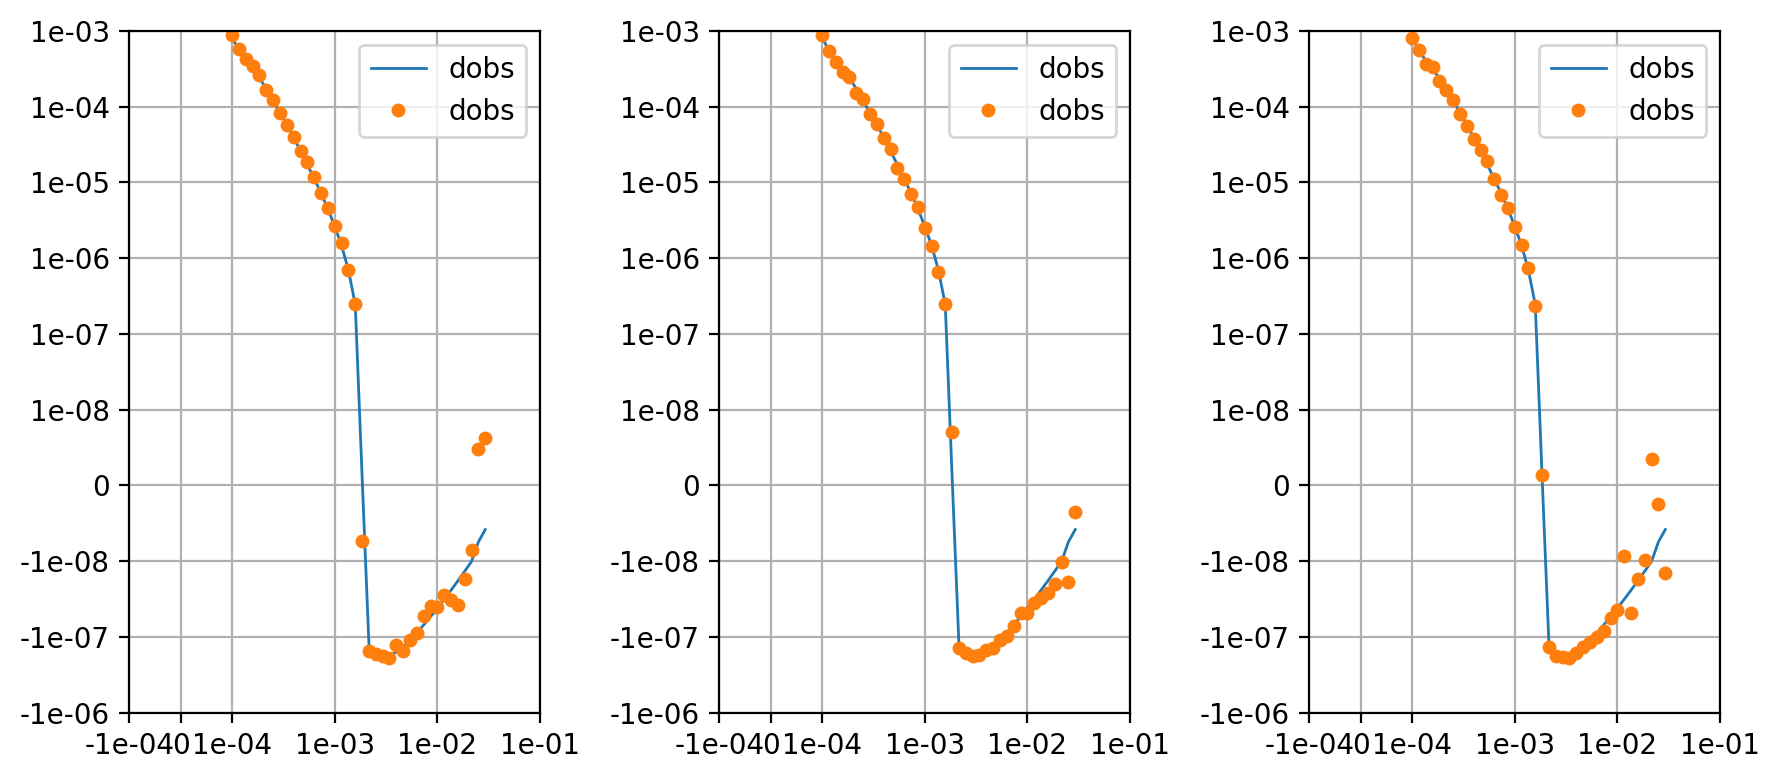

In [18]:
fig, ax= plt.subplots(1,3, figsize=(9,4), dpi=200)
dobs_cmb =[]
ax= ax.flatten()
for i in range(nmodel):
   np.random.seed(i)  # np.random.seed(0)
   mvec_obs = m_trues[i]
   dobs=sim_obs.dpred(mvec_obs)
   dobs_clean =  sim_obs.dpred(mvec_obs)
   # Calculate noise floor and relative erro at each window
   noise_floor = data_noise_floor
   noise_relative = relative_error * np.abs(dobs_clean)

   # Combine the two sources of noise
   total_noise = np.sqrt(noise_floor**2 + noise_relative**2)

   # Add the combined noise to the clean data
   dobs = dobs_clean +  np.random.randn(len(dobs_clean)) * total_noise
   dobs_cmb.append(dobs)
   ax[i]=PL_decay.plpl_plot(x= windows_cen-rmp_time,y=dobs_clean, 
      label="dobs", color="C0", linestyle="-",ax=ax[i]
   )
   ax[i]=PL_decay.plpl_plot(x= windows_cen-rmp_time,y=dobs, 
      label="dobs", color="C1", marker="o",markersize=4,linestyle="",ax=ax[i]
   )
   ax[i]= PL_decay.pl_axes(ax[i])
   ax[i]= PL_decay.pl_axes_x(ax[i])
#for ax in ax:
   ax[i].grid()
   ax[i].legend()
plt.tight_layout()   

# Invert with Debye Decomposition model

In [19]:
taus_strt_log = -3.5
taus_end_log  = -1.75
taus_step_log = 0.25
taus= 10**np.arange(taus_strt_log, taus_end_log+ taus_step_log, taus_step_log)
ntau= len(taus)

In [20]:
# m_ref0 = np.r_[np.log(0.2), np.zeros(ntau)]
# m_ref1 = np.r_[np.log(0.3), np.zeros(ntau)]
# m_ref2 = np.r_[np.log(0.5), np.zeros(ntau)]
# m_refs  = [m_ref0 , m_ref1 , m_ref2 ]
m_refs=[]
rho0_refs = np.r_[0.3, 0.3 , 0.3]
for i in range(nmodel):
    m_ref = np.r_[np.log(rho0_refs[i]), np.zeros(ntau)]
    m_refs.append(m_ref)
    print(m_ref)


[-1.2039728  0.         0.         0.         0.         0.
  0.         0.         0.       ]
[-1.2039728  0.         0.         0.         0.         0.
  0.         0.         0.       ]
[-1.2039728  0.         0.         0.         0.         0.
  0.         0.         0.       ]


In [21]:

sim_tem=empymod_IP_simulation(ip_model='DDR',chgmin=0,
    model_base=empymod_model_sim, nlayer=nlayer,tx_height=tx_height,
    taus=taus, times=times_sim, smp_freq=smp_freq
    )
sim_tem.deepsea_signle_layer(
    res_sea=res_sea, res_base=res_base, eta_sea=eta_sea, eta_base=eta_base
)
m_ref = m_refs[0]
dpred_step= sim_tem.dpred(m_ref)
sim_tem.cut_off = smp_freq/2.0
dpred_LPF = sim_tem.dpred(m_ref)
sim_tem.filt_curr = filt_linrmp
dpred_rmp = sim_tem.dpred(m_ref)
sim_tem.window_mat=Window_mat
dpred_window = sim_tem.dpred(m_ref)


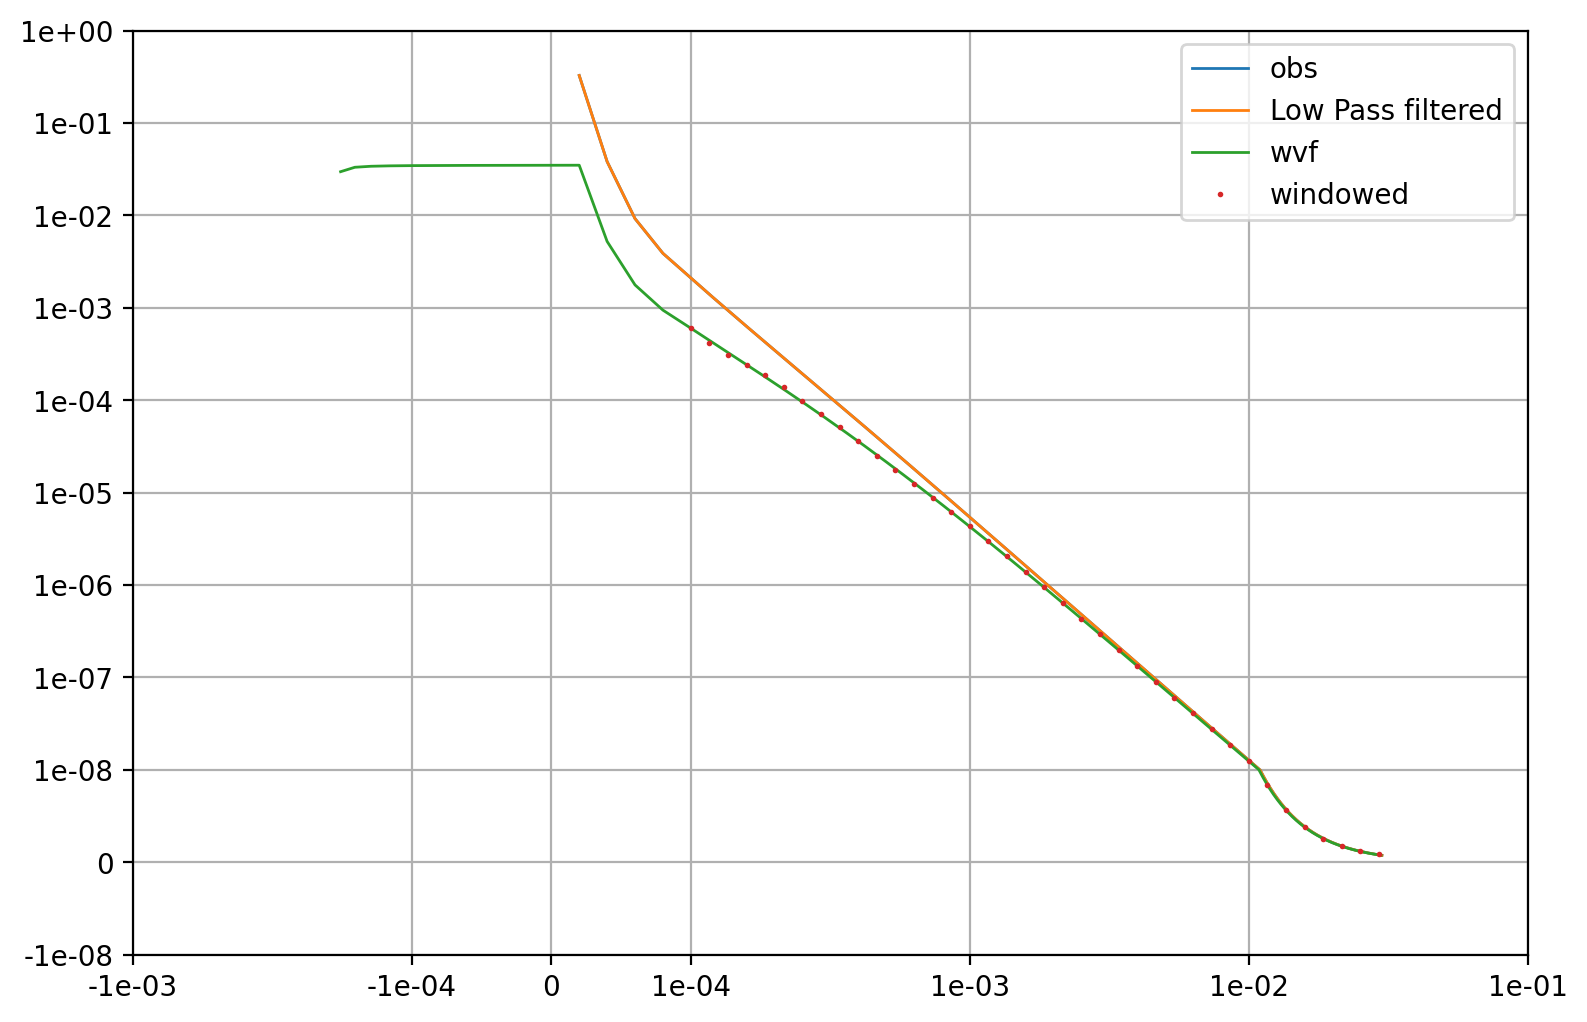

In [22]:
fig, ax= plt.subplots(1,1, figsize=(9,6), dpi=200)

ax=PL_decay.plpl_plot(
     x=times_clc,y=dpred_step , linestyle="-",label="obs", color="C0",ax=ax)
ax=PL_decay.plpl_plot(
     x=times_clc,y=dpred_LPF , linestyle="-",label="Low Pass filtered", color="C1",ax=ax)
ax=PL_decay.plpl_plot(
     x=times_clc-rmp_time,y=dpred_rmp , linestyle="-",label="wvf", color="C2",ax=ax)
ax=PL_decay.plpl_plot(
     x= windows_cen-rmp_time,y=dpred_window , marker="o",linestyle="",label="windowed", color="C3",ax=ax)
ax= PL_decay.pl_axes(ax)
ax = PL_decay.pl_axes_x(ax)
#for ax in ax:
ax.grid()
ax.legend()


# Inversion: Single layer fixed thickness

In [23]:
niter = 50
stol=1e-6
coolingFactor = 2 # np.sqrt(2) 
coolingRate = 2
mu=1e-3
beta0_ratio = 1.0

In [24]:
models_rec = []
dpreds = []
error_prgs = []
model_prgs = []
dinit_refs = []
data_prgs =[]
betas_prgs = []
for i in range(nmodel):
    dobs = dobs_cmb[i]
    m_ref = m_refs[i]

    opt = Optimization(sim=sim_tem, dobs=dobs)
    opt.get_Wd(ratio=relative_error, plateau=data_noise_floor )
    opt.get_Ws(smallness=np.ones(len(m_ref)))
    beta0 = opt.BetaEstimate_byEig(
        mvec=m_ref, update_Wsen=True, beta0_ratio=beta0_ratio)
    print(beta0)
    mpred = opt.GaussNewton(
    mvec_init=m_ref,niter=niter,beta0=beta0, update_Wsen=True,
    stol=stol,mu=mu,coolingRate=coolingRate, coolingFactor=coolingFactor
    )
    
    dinit_refs.append(opt.dpred(m_ref))
    models_rec.append(mpred)
    dpreds.append(opt.dpred(mpred))
    error_prgs.append(opt.error_prg)
    model_prgs.append(opt.mvec_prg)
    data_prgs.append(opt.data_prg)
    betas_prgs.append(opt.betas)


1755730494.128788
  1, beta:1.8e+09, step:1.0e+00, g:4.1e+05, phid:1.3e+04, phim:6.4e-08, f:1.3e+04 
  2, beta:1.8e+09, step:1.0e+00, g:8.8e+03, phid:1.3e+04, phim:6.4e-08, f:1.3e+04 
  3, beta:8.8e+08, step:1.0e+00, g:2.0e+05, phid:1.2e+04, phim:2.5e-07, f:1.3e+04 
  4, beta:8.8e+08, step:1.0e+00, g:8.3e+03, phid:1.2e+04, phim:2.5e-07, f:1.3e+04 
  5, beta:4.4e+08, step:1.0e+00, g:2.0e+05, phid:1.2e+04, phim:9.8e-07, f:1.2e+04 
  6, beta:4.4e+08, step:1.0e+00, g:7.7e+03, phid:1.2e+04, phim:9.9e-07, f:1.2e+04 
  7, beta:2.2e+08, step:1.0e+00, g:2.0e+05, phid:1.1e+04, phim:3.7e-06, f:1.2e+04 
  8, beta:2.2e+08, step:1.0e+00, g:7.8e+03, phid:1.1e+04, phim:3.8e-06, f:1.2e+04 
  9, beta:1.1e+08, step:1.0e+00, g:2.0e+05, phid:9.6e+03, phim:1.3e-05, f:1.1e+04 
 10, beta:1.1e+08, step:9.5e-07, g:1.0e+04, phid:9.6e+03, phim:1.3e-05, f:1.1e+04 
 11, beta:5.5e+07, step:1.0e+00, g:1.9e+05, phid:7.2e+03, phim:4.4e-05, f:9.6e+03 
 12, beta:5.5e+07, step:1.0e+00, g:1.6e+04, phid:6.9e+03, phim:4.9e-0

In [25]:
phid_star=len(windows_cen)
models_rec_phid = []
dpreds_phid = []
phid_star_ratio =1.0
phid_itrs = []
for i in range(nmodel):
    model_prg= np.array(model_prgs[i])
    data_prg = np.array(data_prgs[i])
    error_prg = error_prgs[i]
    phid_prg = np.array(error_prg)[:,1]
    ind = phid_prg < phid_star*phid_star_ratio
    if np.sum(ind) == 0:
        ind = phid_prg == np.min(phid_prg)
    phid_itr = np.where(ind)[0][0]
    models_rec_phid.append(model_prg[ind][0])
    dpreds_phid.append(data_prg[ind][0])
    phid_itrs.append(phid_itr)


In [26]:
models_rec_phid

[array([-1.31658979,  0.01195616,  0.01546132,  0.01602589,  0.019287  ,
         0.02397064,  0.02998917,  0.04369794,  0.06899379]),
 array([-1.26740814,  0.01468864,  0.01504739,  0.01424229,  0.01713346,
         0.02332752,  0.03366425,  0.05131123,  0.0753205 ]),
 array([-1.25276981,  0.01315562,  0.01452078,  0.01406784,  0.01748277,
         0.0245695 ,  0.03545809,  0.05188147,  0.07374131])]

In [27]:
print( "Parameter:  $\\rho_0$, $\\eta$, $\\tau_max$")
np_mvec_ests= []

for i in range(nmodel):
    # mvec_est = models_rec[i]
    np_mvec_ref = m_refs[i]

    mvec_est = models_rec_phid[i]
    np_mvec_ests.append(mvec_est)
    print(f"ref{i+1}     & {np.exp(np_mvec_ref[0]):.2e} & {np_mvec_ref[1:].sum():.3f} ")
    print(f"est{i+1}     & {np.exp(mvec_est[0]):.2e} & { mvec_est[1:].sum():.3f}")


Parameter:  $\rho_0$, $\eta$, $\tau_max$
ref1     & 3.00e-01 & 0.000 
est1     & 2.68e-01 & 0.229
ref2     & 3.00e-01 & 0.000 
est2     & 2.82e-01 & 0.245
ref3     & 3.00e-01 & 0.000 
est3     & 2.86e-01 & 0.245


findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


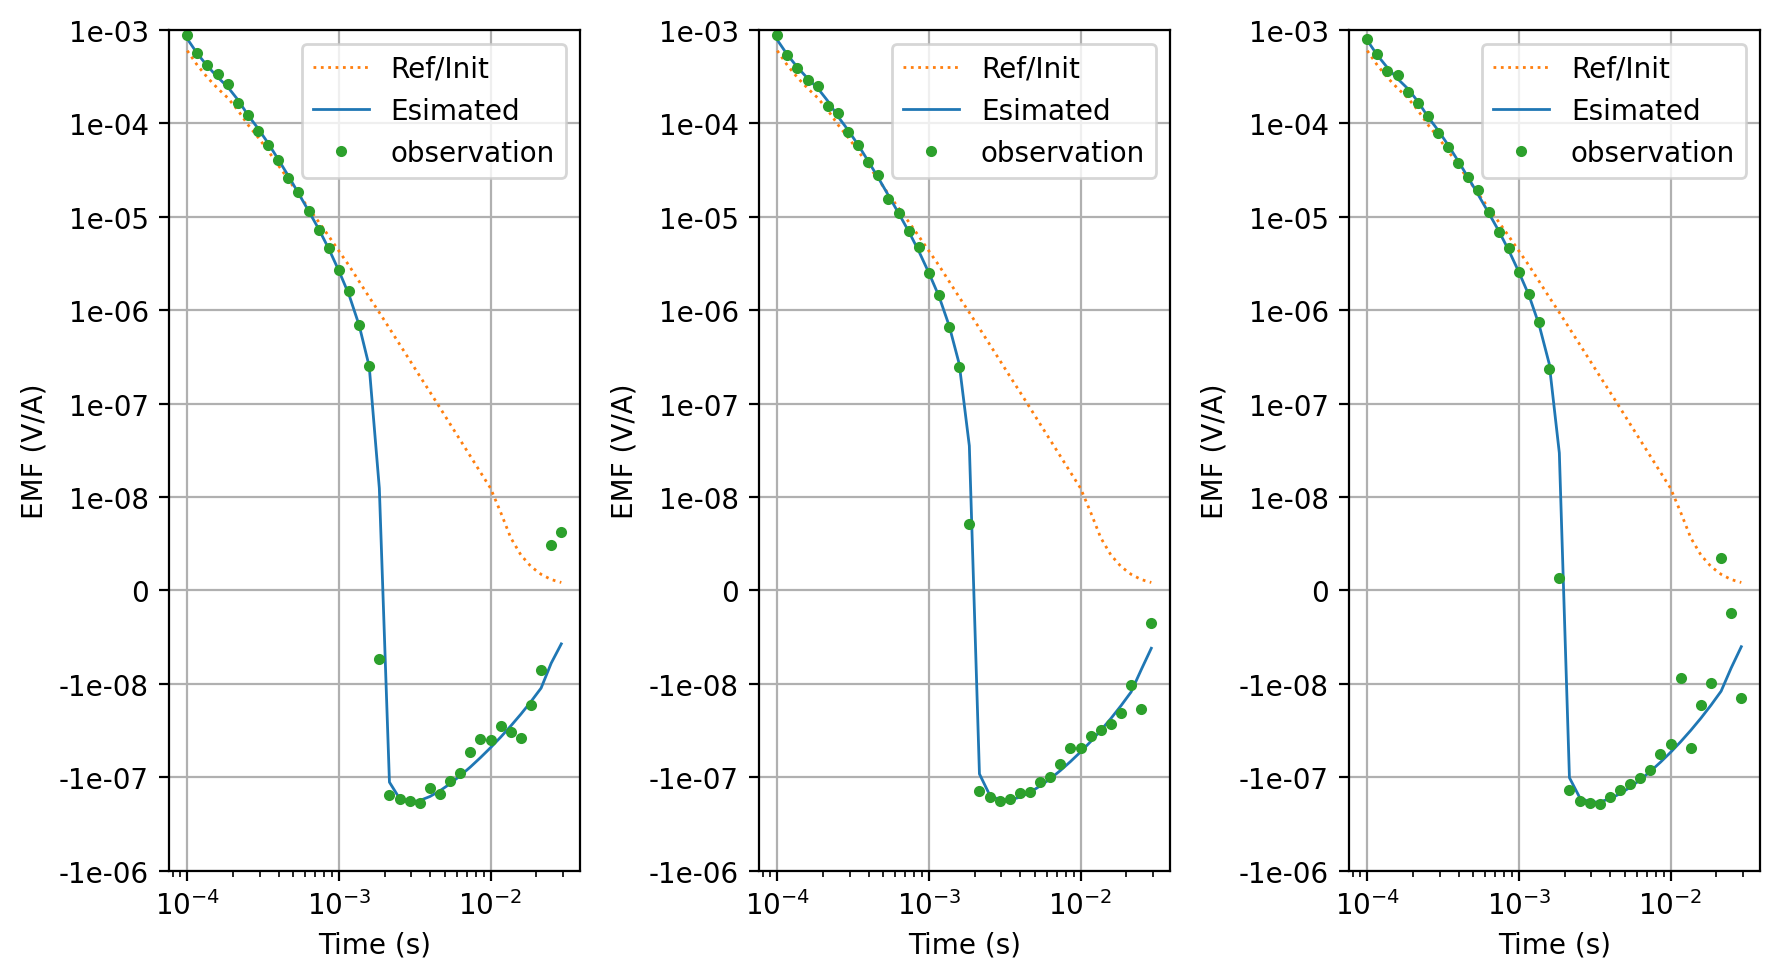

In [28]:
fig, ax= plt.subplots(1,3, figsize=(9,5), dpi=200)
ax= ax.flatten()
for i in range(nmodel):
    dobs= dobs_cmb[i]   
    dinit_ref = dinit_refs[i]

    ax[i]=PL_decay.semiply(
        windows_cen-rmp_time, dinit_ref, ax=ax[i],
        color=f"C1",linestyle=":", label=f"Ref/Init"
        )

    ax[i]=PL_decay.semiply(
        windows_cen-rmp_time, dpreds_phid[i], ax=ax[i],
        color=f"C0",linestyle="-", label=f"Esimated"
        )
    ax[i]=PL_decay.semiply(
        windows_cen-rmp_time, dobs, ax=ax[i], marker="o",markersize=3.0,
        color=f"C2",linestyle="", label="observation"
        )
    ax[i] = PL_decay.pl_axes(ax[i])
    ax[i].grid()
    ax[i].legend()
    ax[i].set_xlabel("Time (s)")
    ax[i].set_ylabel("EMF (V/A)")
plt.tight_layout()

# get SIP of target layer

In [29]:
freq_step_log  = 0.1
freq = 10**np.arange(-taus_end_log, -taus_strt_log+freq_step_log, freq_step_log)
freq /= 2.0*np.pi
nfreq=len(freq)
freq_min = freq.min()
freq_max = freq.max()
print(freq_min)
freq_ext = 10.**np.arange(-1,5.1,0.1)

8.949940160889103


In [30]:
relative_error = 0.05
noise_floor_ratio = 1e-3
niter = 100
stol=1e-6
coolingFactor = np.sqrt(2) # 2 
coolingRate = 2
mu=1e-3
beta0_ratio = 1.0

In [31]:
sip_true =[]
sip_true_ext = []
sip_dpreds = []
model_recs = []
error_prgs = []
model_prgs = []
data_prgs =[]
betas_prgs = []
for i in range(nmodel):
    IP_model = Pelton_res_f(freq=freq)
    sim_sip = InducedPolarizationSimulation(ip_model=IP_model, mode='sip')
    mvec_obs = m_trues[i]

    dobs = sim_sip.dpred(m=mvec_obs)
    sip_true.append(dobs)
    f_abs = abs(IP_model.f(mvec_obs))
    noise_floor= f_abs.max()*noise_floor_ratio

    IP_model = Pelton_res_f(freq=freq_ext)
    sim_sip = InducedPolarizationSimulation(ip_model=IP_model, mode='sip')
    sip_true_ext.append(sim_sip.dpred(m_trues[i]))


    IP_model = DDR_f(freq=freq,taus=taus)
    sim = InducedPolarizationSimulation(ip_model=IP_model, mode='sip')
    sip_dpreds.append(sim.dpred(models_rec_phid[i]))
    m_ref = m_refs[i]   
    
    opt = Optimization(sim=sim, dobs= dobs)
    opt.get_Wd(ratio=relative_error, plateau=noise_floor)
    opt.get_Ws(np.ones(len(m_ref)))
    beta0 = opt.BetaEstimate_byEig(mvec=m_ref, update_Wsen=True)
    mpred = opt.GaussNewton(
        mvec_init=m_ref,niter=niter,beta0=beta0, update_Wsen=True,
        stol=stol,mu=mu,coolingRate=coolingRate, coolingFactor=coolingFactor
        )
    model_recs.append(mpred)
    error_prgs.append(opt.error_prg)
    model_prgs.append(opt.mvec_prg)
    data_prgs.append(opt.data_prg)
    betas_prgs.append(opt.betas)


  1, beta:6.0e+07, step:1.0e+00, g:1.2e+05, phid:3.8e+03, phim:2.7e-06, f:3.9e+03 
  2, beta:6.0e+07, step:1.0e+00, g:3.7e+02, phid:3.8e+03, phim:2.7e-06, f:3.9e+03 
  3, beta:4.2e+07, step:1.0e+00, g:3.3e+04, phid:3.6e+03, phim:5.2e-06, f:3.9e+03 
  4, beta:4.2e+07, step:1.0e+00, g:1.4e+02, phid:3.6e+03, phim:5.2e-06, f:3.9e+03 
  5, beta:3.0e+07, step:1.0e+00, g:3.2e+04, phid:3.5e+03, phim:9.8e-06, f:3.8e+03 
  6, beta:3.0e+07, step:1.0e+00, g:1.9e+02, phid:3.5e+03, phim:9.8e-06, f:3.8e+03 
  7, beta:2.1e+07, step:1.0e+00, g:3.1e+04, phid:3.3e+03, phim:1.8e-05, f:3.7e+03 
  8, beta:2.1e+07, step:1.0e+00, g:2.5e+02, phid:3.3e+03, phim:1.8e-05, f:3.7e+03 
  9, beta:1.5e+07, step:1.0e+00, g:3.0e+04, phid:3.0e+03, phim:3.3e-05, f:3.5e+03 
 10, beta:1.5e+07, step:1.0e+00, g:3.1e+02, phid:3.0e+03, phim:3.3e-05, f:3.5e+03 
 11, beta:1.1e+07, step:1.0e+00, g:2.9e+04, phid:2.7e+03, phim:5.9e-05, f:3.3e+03 
 12, beta:1.1e+07, step:1.0e+00, g:3.7e+02, phid:2.7e+03, phim:5.8e-05, f:3.3e+03 
 13,

 71, beta:3.2e+02, step:1.0e+00, g:7.8e+00, phid:3.6e-01, phim:4.2e-03, f:1.7e+00 
 72, beta:3.2e+02, step:1.0e+00, g:5.5e-02, phid:3.6e-01, phim:4.2e-03, f:1.7e+00 
 73, beta:2.3e+02, step:5.0e-01, g:5.6e+00, phid:3.4e-01, phim:4.3e-03, f:1.3e+00 
 74, beta:2.3e+02, step:1.2e-01, g:2.8e+00, phid:3.3e-01, phim:4.3e-03, f:1.3e+00 
 75, beta:1.6e+02, step:1.2e-01, g:6.4e+00, phid:4.1e-01, phim:4.3e-03, f:1.1e+00 
 76, beta:1.6e+02, step:9.5e-07, g:3.6e+02, phid:4.1e-01, phim:4.3e-03, f:1.1e+00 
 77, beta:1.1e+02, step:6.2e-02, g:3.6e+02, phid:6.0e-01, phim:4.4e-03, f:1.1e+00 
 78, beta:1.1e+02, step:9.5e-07, g:6.8e+02, phid:6.0e-01, phim:4.4e-03, f:1.1e+00 
 79, beta:8.1e+01, step:1.6e-02, g:6.7e+02, phid:7.1e-01, phim:4.4e-03, f:1.1e+00 
 80, beta:8.1e+01, step:9.5e-07, g:7.9e+02, phid:7.1e-01, phim:4.4e-03, f:1.1e+00 
 81, beta:5.7e+01, step:7.8e-03, g:7.9e+02, phid:7.8e-01, phim:4.4e-03, f:1.0e+00 
 82, beta:5.7e+01, step:9.5e-07, g:8.7e+02, phid:7.8e-01, phim:4.4e-03, f:1.0e+00 
 83,

In [32]:
phid_star_ratio = 1.0
sip_true_inv = []
sip_true_dpred = []
for i in range(nmodel):
    phid_star = nfreq*2
    model_prg= np.array(model_prgs[i])
    data_prg = np.array(data_prgs[i])
    error_prg = error_prgs[i]
    phid_prg = np.array(error_prg)[:,1]
    ind = phid_prg < phid_star*phid_star_ratio
    if np.sum(ind) == 0:
        ind = phid_prg == np.min(phid_prg)
    sip_true_inv.append(model_prg[ind][0])
    sip_true_dpred.append(data_prg[ind][0])


In [33]:
sip_true_inv

[array([-1.33661029,  0.01992615,  0.01702601,  0.01621965,  0.01702502,
         0.01995398,  0.02662018,  0.03909942,  0.06056261]),
 array([-1.33661029,  0.01992615,  0.01702601,  0.01621965,  0.01702502,
         0.01995398,  0.02662018,  0.03909942,  0.06056261]),
 array([-1.33661029,  0.01992615,  0.01702601,  0.01621965,  0.01702502,
         0.01995398,  0.02662018,  0.03909942,  0.06056261])]

In [34]:
def plot_data(iteration, ax=None):
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(5,3))
       
    ax=PL_decay.semiply(windows_cen-rmp_time, data_init, ax=ax,
                       color="C1",label="Ref"
                       )
    ax=PL_decay.semiply(windows_cen-rmp_time, dpreds, ax=ax
                        ,color="C0",linestyle="-",
                        label=f"Est" #, iter={iteration}"
                        )
    ax=PL_decay.semiply(windows_cen-rmp_time, dobs, ax=ax, marker="o",markersize=3.0,
                       color="C2",linestyle="", label="Obs"
                       )
    ax = PL_decay.pl_axes(ax)
    # ax.grid()
    # ax.legend()
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("EMF (V/A)")
    ax.set_title(f""" Data plot
Relative error {relative_error*100:.1f} %, noise floor {data_noise_floor:.1e} V/A""")
    return ax

In [ ]:
def plot_sip(freq, dpreds, ax=None, **kwargs):
    if ax is None: 
        fig, ax = plt.subplots(2, 1, figsize=(5,3))
    nfreq = len(freq)

    default_kwargs = {
        "linestyle": "-",
        "color": "C0",
        "linewidth": 1.0,
        "marker": None,
        "markersize": 1,
    }
    default_kwargs.update(kwargs)
    nfreq = len(dpreds)//2

    sip_real = dpreds[:nfreq]
    sip_imag = dpreds[nfreq:]
    sip_abs = np.abs(sip_real + 1j * sip_imag)
    sip_phs = np.angle(sip_real + 1j * sip_imag, deg=True)
    ax[0].semilogx(freq, sip_abs, **default_kwargs)
    ax[1].semilogx(freq, sip_phs, **default_kwargs)

    ax[0].set_ylim(bottom=0)
    ax[0].set_ylabel(r'$|\rho^{\ast}|~(\Omega\cdot\mathrm{m})$')
    ax[1].set_ylabel(r'$\phi~(^\circ)~(\mathrm{deg}) $')

    for a in ax:
        a.set_xlabel("Frequency [Hz]")

    return ax

In [36]:
def plot_etas_model(model,taus, ax=None, **kwargs):
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(5,3))
    etas = model[1:]

    ax.semilogx(taus, etas, **kwargs)
    ax.set_xlabel(r"$\tau_j$ [s]")
    ax.set_ylabel(r"$\eta_j$")
    return ax

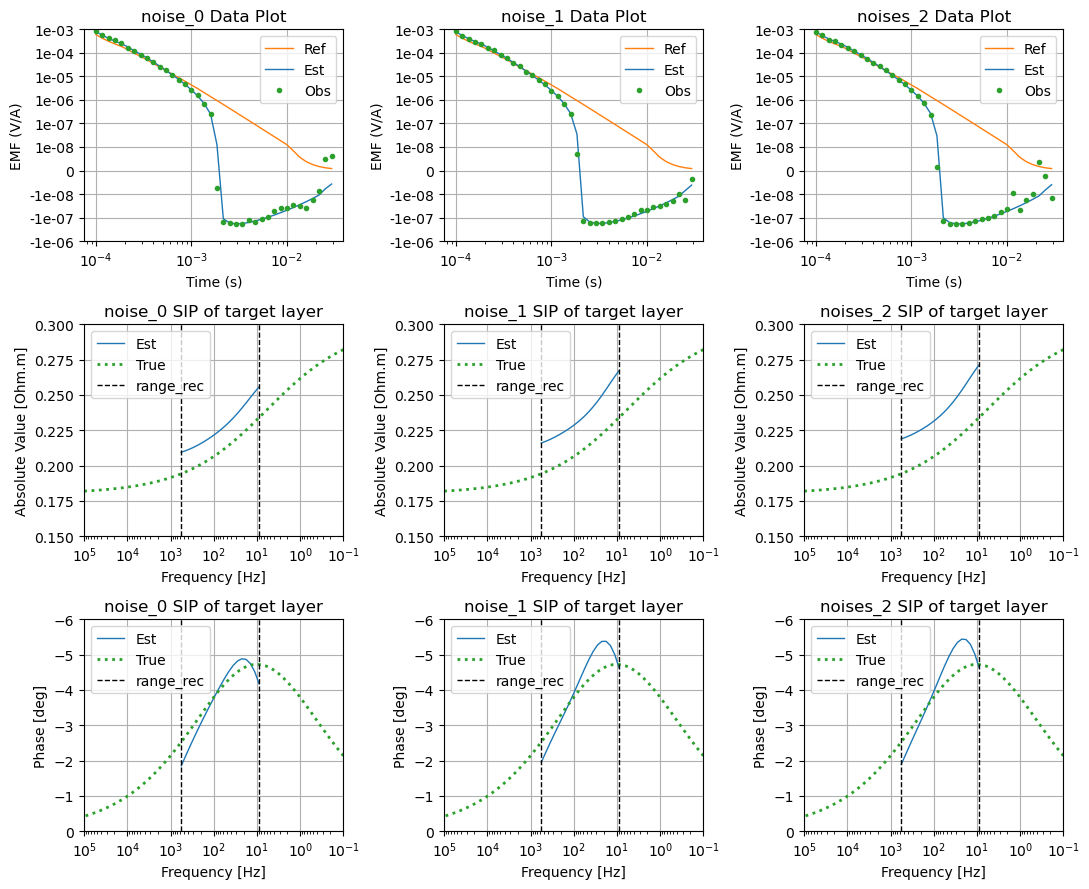

In [37]:
fig, ax = plt.subplots(3, 3, figsize=(11,9))
title_heads = ["noise_0", "noise_1", "noises_2"]
ax_ranges = []
ax_ranges.append([ax[0, 0], ax[1, 0], ax[2, 0]])
ax_ranges.append([ax[0, 1], ax[1, 1], ax[2, 1]])
ax_ranges.append([ax[0, 2], ax[1, 2], ax[2, 2]])
for i in range(nmodel):
    title_head = title_heads[i]
    phid_itr = phid_itrs[i]
    data_init = dinit_refs[i]
    dpreds = dpreds_phid[i]
    dobs= dobs_cmb[i]
    ax_range = ax_ranges[i]
    axdata = ax_range[0]
    axdata = plot_data(iteration=phid_itr, ax=axdata)
    axsip = [ax_range[1], ax_range[2]]
    axsip = plot_sip(freq, sip_dpreds[i], 
             ax=axsip, color="C0", label=f"Est", linestyle="-"
             )
    # axsip = plot_sip(freq, sip_true_dpred[i], 
    #          ax=axsip, color="C1", label=f"Estimated by sip", linestyle="-"
    #          )
    axsip  = plot_sip(freq=freq_ext,
              dpreds=sip_true_ext[i],ax=axsip, color="C2", label=f"True", linestyle=":",
              linewidth=2.0)
    axsip[0].set_ylim(bottom=0.15,top=0.3)
    axsip[1].set_ylim(top=-6, bottom=0)
    axsip[0].axvline(x=freq_min, color='k', linestyle='--', linewidth=1.0,
                     label=f"range_rec"
                     )
    axsip[0].axvline(x=freq_max, color='k', linestyle='--', linewidth=1.0)
    axsip[1].axvline(x=freq_min, color='k', linestyle='--', linewidth=1.0,
                     label=f"range_rec"
                     )
    axsip[1].axvline(x=freq_max, color='k', linestyle='--', linewidth=1.0)

    for a in axsip:
        a.set_xlim(left=1e5, right=0.1)
        # a.set_ylim(left=1e3, right=1)
        
    for a in ax_range:
        a.legend()
        a.grid()

    ax_range[0].set_title(f"{title_head} Data Plot")
    ax_range[1].set_title(f"{title_head} SIP of target layer")
    ax_range[2].set_title(f"{title_head} SIP of target layer")

plt.tight_layout()
plt.savefig('45_DD_data.jpg', dpi=300)

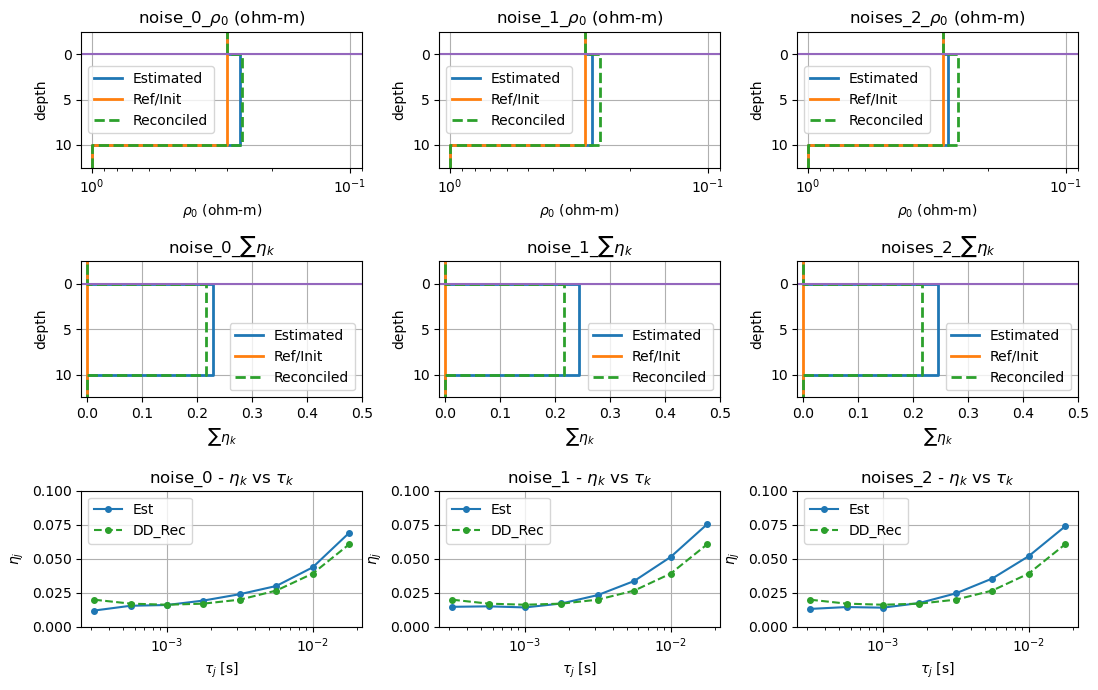

In [38]:
fig, ax = plt.subplots(3, 3, figsize=(11,7))
ax_range = []
ax_range.append([ax[0, 0], ax[1, 0], ax[2, 0]])
ax_range.append([ax[0, 1], ax[1, 1], ax[2, 1]])
ax_range.append([ax[0, 2], ax[1, 2], ax[2, 2]])
for i in range(nmodel):
    title_head = title_heads[i]
    m_tem = models_rec_phid[i]
    m_ref = m_refs[i]
    m_sip = sip_true_inv[i] 
    m_true = sip_true_inv[i]

    axtmp  = ax_range[i]
    axrm   = ax_range[i][0:2]
    axetas = ax_range[i][2]
    axrm = sim_tem.plot_IP_par(mvec=m_tem, rm=True,
            label="Estimated", color=f"C0", linestyle="-", 
            ax=axrm, linewidth=2.0)
    rho0,eta = sim.ip_model.get_rho_eta(models_rec_phid[i])
    label = fr"est_$\rho_0$: {rho0: .1e}, $\eta$: {eta: .2f}"
    axetas = plot_etas_model(models_rec_phid[i], taus,
             ax=axetas, color="C0",
             label="Est",
             linestyle="-", marker='o', markersize=4
             )
    
    axrm = sim_tem.plot_IP_par(mvec=m_ref, rm=True, 
            label="Ref/Init", color=f"C1", linestyle="-",
            ax=axrm, linewidth=2.0)

    # label = fr"est_$\rho_0$: {rho0: .1e}, $\eta$: {eta: .2f}"

    axrm = sim_tem.plot_IP_par(mvec=m_true, rm=True, 
            label="Reconciled", color=f"C2", linestyle="--",
            ax=axrm, linewidth=2.0)
    # rho0,eta = sim.ip_model.get_rho_eta(sip_true_inv[i])
    # label = fr"tru_$\rho_0$: {rho0: .1e}, $\eta$: {eta: .2f}"
    axetas = plot_etas_model(sip_true_inv[i], taus,
             ax=axetas, color="C2", label="DD_Rec",
            linestyle="--", marker='o', markersize=4
             )
    axrm[0].set_xlim([1.1,0.09])
    axrm[1].set_xlim([-0.01,0.5])
    axetas.set_ylim([0, 0.10])
    for a in (axtmp):
        a.grid()
        a.legend()
        # if j >= 2:  # Only show legend for ax[2] and ax[3]
        #     a.legend(loc='upper left', fontsize='small')

    for j , a in enumerate(axrm):  # Iterate over rows
        a.axhline(empymod_model_sim["src"][4], color=f"C4", linestyle="-", label="Src+Rec")
        a.set_ylim([12.5, -2.5])
        a.set_ylabel('depth')
        if j== 0 :
            a.set_xscale("log")
        else:
            a.set_xscale("linear")
    axrm[0].set_title(fr"{title_head}_$\rho_0$ (ohm-m)")
    axrm[1].set_title(fr"{title_head}_$\sum\eta_k$")
    axetas.set_title(fr"{title_head} - $\eta_k$ vs $\tau_k$")

# ax_right = [ax[0,3], ax[1,3], ax[2,3]]
# for a in ax_right:
#     a.axis("off")
# handles, labels = axtmp[1].get_legend_handles_labels()
# ax[1,3].legend(handles, labels)

# handles, labels = axtmp[2].get_legend_handles_labels()
# ax[2,3].legend(handles, labels)

plt.tight_layout()
plt.savefig('45_Recovered.jpg', dpi=300)

In [39]:
def plot_each_data(data, ax=None, **kwargs):
    default_kwargs = {
        "linestyle": "-",
        "color": "C0",
        "linewidth": 1.0,
        "marker": None,
        "markersize": 1,
    }
    default_kwargs.update(kwargs)
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(5,3))
       
    ax=PL_decay.semiply(windows_cen-rmp_time, data, ax=ax,
                       **default_kwargs
                       )
    ax = PL_decay.pl_axes(ax)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("EMF (V/A)")
    ax.set_title(f""" Data plot
Relative error {relative_error*100:.1f} %, noise floor {data_noise_floor:.1e} V/A""")
    return ax

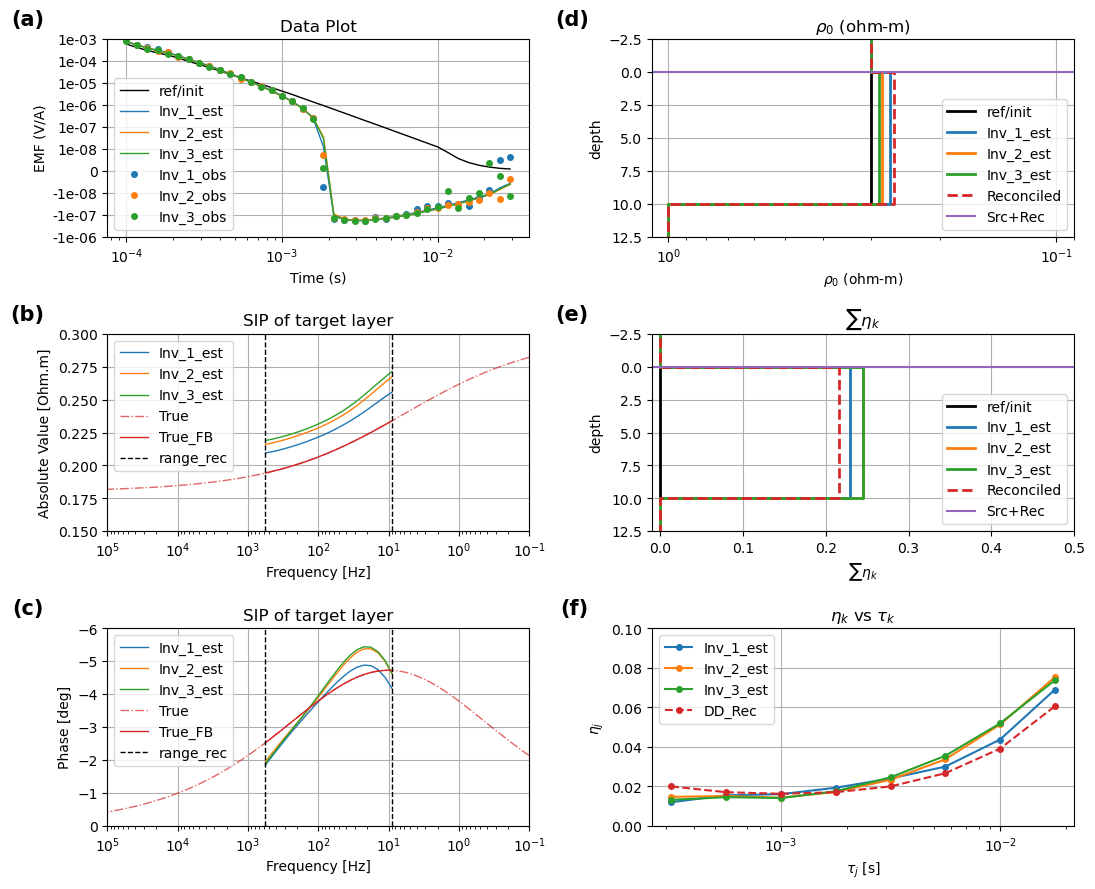

In [40]:

title_heads = ["Inv_1", "Inv_2", "Inv_3"] #  ["ref_0", "ref_1", "ref_2"] 

fig,ax = plt.subplots(3,2,figsize=(11, 9))
ax =ax.flatten()
axdata = ax[0]
axsip = [ax[2], ax[4]]
axmodel = [ax[1], ax[3]]
axetas = ax[5]
data_init = dinit_refs[0]

axdata = plot_each_data(data=data_init,
            label=f"ref/init",color=f"k", 
            ax=axdata)
m_ref = m_refs[0]
axmodel= sim_tem.plot_IP_par(mvec=m_ref, rm=True,
    label="ref/init", color="k", linestyle="-", 
    ax=axmodel, linewidth=2.0)

for i in range(nmodel):
    title_head = title_heads[i]
    dpreds = dpreds_phid[i]
    m_tem = models_rec_phid[i]

    ax_range = ax_ranges[i]
    axdata = plot_each_data(data=dpreds,
             label=f"{title_head}_est",color=f"C{i}", 
             ax=axdata)
    axsip = plot_sip(freq, sip_dpreds[i], 
             ax=axsip, color=f"C{i}", label=f"{title_head}_est"
             )
    axmodel= sim_tem.plot_IP_par(mvec=m_tem, rm=True, 
        label=f"{title_head}_est", color=f"C{i}", linestyle="-", 
        ax=axmodel, linewidth=2.0)

    axetas = plot_etas_model(m_tem, taus,
             ax=axetas, color=f"C{i}",
             label=f"{title_head}_est",
             linestyle="-", marker='o', markersize=4
             )
m_true = sip_true_inv[0]
axmodel = sim_tem.plot_IP_par(mvec=m_true, rm=True, 
            label="Reconciled", color=f"C{nmodel}", linestyle="--",
            ax=axmodel, linewidth=2.0)

for i in range(nmodel):
    title_head = title_heads[i]
    dobs= dobs_cmb[i]
    axdata = plot_each_data(data=dobs,
             label=f"{title_head}_obs",color=f"C{i}", 
             linestyle="", marker="o", markersize=4.0,
             ax=axdata)

axsip  = plot_sip(freq=freq_ext,
            dpreds=sip_true_ext[0],ax=axsip,
            color=f"C{nmodel}", label=f"True",
            linestyle="-.", alpha=0.7)

axsip  = plot_sip(freq=freq,
            dpreds=sip_true[0],ax=axsip,
            color=f"C{nmodel}", label=f"True_FB")
           
axetas = plot_etas_model(sip_true_inv[0], taus,
             ax=axetas, color=f"C{nmodel}", label="DD_Rec",
            linestyle="--", marker='o', markersize=4
             )
axsip[0].set_ylim(bottom=0.15, top=0.30)
axsip[1].set_ylim(top=-6, bottom=0)
for a in axsip:
    a.set_xlim(left=1e5, right=0.1)


axsip[0].set_ylim(bottom=0.15,top=0.3)
axsip[0].axvline(x=freq_max, color='k', linestyle='--', linewidth=1.0)
axsip[0].axvline(x=freq_min, color='k', linestyle='--', linewidth=1.0,
                    label=f"range_rec"
                    )
axsip[1].set_ylim(top=-6, bottom=0)
axsip[1].axvline(x=freq_min, color='k', linestyle='--', linewidth=1.0,
                    label=f"range_rec"
                    )
axsip[1].axvline(x=freq_max, color='k', linestyle='--', linewidth=1.0)


axdata.set_title(f"Data Plot")
axsip[0].set_title(f"SIP of target layer")
axsip[1].set_title(f"SIP of target layer")

axmodel[0].set_xlim([1.1,0.09])
axmodel[1].set_xlim([-0.01,0.5])
axetas.set_ylim([0, 0.10])
axmodel[0].set_title(r"$\rho_0$ (ohm-m)")
axmodel[1].set_title(r"$\sum\eta_k$")
axetas.set_title(r"$\eta_k$ vs $\tau_k$")


for j , a in enumerate(axmodel):  # Iterate over rows
    a.axhline(empymod_model_sim["src"][nmodel+1], color=f"C4", linestyle="-", label="Src+Rec")
    a.set_ylim([12.5, -2.5])
    a.set_ylabel('depth')
    if j== 0 or j==2:
        a.set_xscale("log")
    else:
        a.set_xscale("linear")

for a in ax:
    a.legend()
    a.grid()

panel_labels = ['(a)', '(d)', '(b)', '(e)', '(c)', '(f)']

for label, axis in zip(panel_labels, ax):
    axis.text(
        -0.15, 1.05, label,
        transform=axis.transAxes,
        fontsize=15, fontweight='bold',
        va='bottom', ha='right'
    )

plt.tight_layout()
plt.savefig('45_DD.jpg', dpi=300)